# This program aims at getting a plot of each txt file in a folder containig exclusively raman txt files 


In [1]:
from datetime import datetime
from datetime import date

def date_today():
    tdy=str(date.today())
    tdy=tdy.replace('-', '_')
    return tdy

def date_time():
    now=str(datetime.now())
    now=now[:-7]
    now=now.replace('-','_')
    now=now.replace(' ', '_')
    now=now.replace(':', '-')
    now=now+'_'
    return now
print(date_time())
print(date_today())

2021_12_02_14-41-02_
2021_12_02


In [2]:
import os
import csv 
import matplotlib.pyplot as plt
import numpy as np
from tkinter import *
from tkinter import filedialog
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [47]:
'''Takes 1D list or array in y, smoothing parameters in lam and p. 
For normalized spectrum so far lam=10e7 to 10e8 and p=1e-7 works quite ok as starting point for raman. niter is number of iteration which was not played with'''
def baseline_f(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

'''Baseline definition and substraction'''
def baseline_find(arr, lam, p):
    baseline=baseline_f(arr,lam, p)
    sub_base_data=arr-baseline
    plt.plot(arr,label='data')
    plt.plot(baseline,label='baseline')
    plt.plot(sub_base_data,label='substracted data')
    plt.show()
    checkok='y'
    print('Is baseline ok?')
    chkbaseline=input('(y=yes ; other=no): ')
    while chkbaseline != checkok:
        print('Previous lambda : ', lam, '\n Define new lambda (input integer(ex:10)=change, other(ex:f)=keep):')
        lam_inp=input('Lambda = ')
        print('Previous p : ', p, '\n Define new p (input float(ex:0.10)=change, other(ex:f)=keep ): ')
        p_inp=input('p = ')
        if lam_inp.isnumeric():
            lam=int(lam_inp)
        if p_inp.isnumeric():
            p=float(p_inp)
        baseline=baseline_f(arr,lam,p)
        sub_base_data=arr-baseline
        plt.plot(arr, label='data')
        plt.plot(baseline,label='baseline')
        plt.plot(sub_base_data,label='substracted data')
        plt.show()
        print('Is baseline ok?')
        chkbaseline=input('(y=yes ; other=no): ')
    final=sub_base_data
    return final
    
    

'''Takes data and calculates average in defined window (half above half below)
BEWARE regarding first and last values, always check output especially with big window (box_pts)'''
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    checkOK='y'
    for i in range(box_pts+2):
        y_smooth[i]=y_smooth[box_pts+2]
        y_smooth[-i-1]=y_smooth[-box_pts-2]
    plt.plot(y_smooth)
    plt.show()
    print('\n Is smoothed data acceptable?')
    check_smooth=input('(y=YES ; other=NO')
    while check_smooth != checkOK:
        print('Previous Box size was: ',box_pts)
        box_pts=int(input('New Box size:'))
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        for i in range(box_pts+2):
            y_smooth[i]=y_smooth[box_pts+2]
            y_smooth[-i-1]=y_smooth[-box_pts-2]
        plt.plot(y_smooth)
        plt.show()
        print('\n Is smoothed data acceptable?')
        check_smooth=input('(y=YES ; other=NO')
    return y_smooth

'''Directory selection to later read all relevant files from directory
WARNING: do not forget '/' or '\\' (python vs win) before file name'''
def dir_select(start_dir = None):
    root=Tk()
    directory=filedialog.askdirectory(initialdir=start_dir)
    root.destroy()
    print(directory)
    return directory

''' Creates list with all files pertaining to relevant extension'''
def all_extension_select(directory, extension):
    all_files_names=os.listdir(directory)
#    print(all_files_names , '\n')
    txt_files=list()
    for a in range(len(all_files_names)):
        if all_files_names[a].find(extension)>0:
            txt_files.insert(a, all_files_names[a])
    print(txt_files)
    return txt_files

'''1D array normalisation from 0 to 1        '''
def array_norm(arr):
    datamax=np.max(arr)
    datamin=np.min(arr)
    norm_arr=np.array([(x - datamin)/(datamax - datamin) for x in arr])
    return norm_arr

'''Find local/peak maximum in given interval'''
def find_max_btwn_x(x, arr, xmin, xmax):
    index_min=0
    while x[index_min]<xmin:
        index_min+=1
        if index_min>len(x):
            print('Lower x boundary out of range')
            break
    index_max=index_min
    while x[index_max]<xmax:
        index_max+=1
        if index_min>len(x):
            print('Higher xboundary out of range')
            break
    loc_max=np.max(arr[index_min:index_max])
    return loc_max

'''Find local/peak maximum in given interval'''
def find_min_btwn_x(x, arr, xmin, xmax):
    index_min=0
    while x[index_min]<xmin:
        index_min+=1
        if index_min>len(x):
            print('Lower x boundary out of range')
            break
    index_max=index_min
    while x[index_max]<xmax:
        index_max+=1
        if index_min>len(x):
            print('Higher xboundary out of range')
            break
    loc_min=np.min(arr[index_min:index_max])
    return loc_min

'''Plots raw data graphs'''
def plot_raw_graphs(txt_files, directory, newpath):
    IDpeak=1345
    IGpeak=1590
    I2Dpeak=2690
    for i in range(len(txt_files)):
    #for i in range(3):
        with open(directory + '/' + txt_files[i], 'r') as f:
            data=np.genfromtxt(f,delimiter='\t')
            fig=plt.figure(1, figsize=(5,5))
            plt.plot(data[:,0], data[:,1], color='#351c75')
            plt.xlabel('Wavenumber (cm$^⁻$$^1$)', fontsize=14)
            plt.ylabel('Intensity (a.u.)', fontsize=14)
            plt.title('Raman shift, laser:532nm', fontsize=14)
            plt.minorticks_on()
            plt.tick_params(direction='in', which='major', length=6)
            plt.tick_params(direction='in', which='minor', length=3)


            if max(data[:,0]) > I2Dpeak:
                plt.axvline(x=I2Dpeak, linestyle='--', color='#c27ba0')
                plt.text(x=I2Dpeak+50, y=0.99*max(data[:,1]), s='2D', fontsize=14, color='#c27ba0')
                plt.axvline(x=IDpeak, linestyle='--', color='#741b47')
                plt.text(x=IDpeak-200, y=0.99*max(data[:,1]), s='D', fontsize=14, color='#741b47')
                plt.axvline(x=IGpeak, linestyle='--', color='#a64d79')
                plt.text(x=IGpeak+50, y=0.99*max(data[:,1]), s='G', fontsize=14, color='#a64d79')

            elif max(data[:,0]) < I2Dpeak:
                plt.axvline(x=IDpeak, linestyle='--', color='#741b47')
                plt.text(x=IDpeak+10, y=0.99*max(data[:,1]), s='D', fontsize=14, color='#741b47')
                plt.axvline(x=IGpeak, linestyle='--', color='#a64d79')
                plt.text(x=IGpeak+10, y=0.99*max(data[:,1]), s='G', fontsize=14, color='#a64d79')
            plt.savefig(newpath + '/RAW-'+txt_files[i][:-4]+'.png', dpi=100)
            #plt.show()
            plt.close()

    print('Raw Graphs Saved')
    return None 

'''Plots normalized/scaled graphs'''
def plot_norm_graphs(txt_files, directory, newpath):
    IDpeak=1345
    IGpeak=1590
    I2Dpeak=2690
    for i in range(len(txt_files)):
    #for i in range(3):
        with open(directory + '/' + txt_files[i], 'r') as f:
            data=np.genfromtxt(f,delimiter='\t')
            fig1=plt.figure(2, figsize=(5,5))
            normd_data=array_norm(data[:,1])
            plt.plot(data[:,0],normd_data, color='#011f4b')
            plt.xlabel('Wavenumber (cm$^⁻$$^1$)', fontsize=14)
            plt.ylabel('Normalized intensity (a.u.)', fontsize=14)
            plt.title('Raman shift, laser:532nm')
            plt.minorticks_on()
            plt.tick_params(direction='in', which='major', length=6)
            plt.tick_params(direction='in', which='minor', length=3)

            if max(data[:,0]) > I2Dpeak:
                plt.axvline(x=I2Dpeak, linestyle='--', color='#5e4a6f')
                plt.text(x=I2Dpeak+50, y=0.99*max(normd_data), s='2D', fontsize=14, color='#5e4a6f')
                plt.axvline(x=IDpeak, linestyle='--', color='#371e4c')
                plt.text(x=IDpeak-200, y=0.99*max(normd_data), s='D', fontsize=14, color='#371e4c')
                plt.axvline(x=IGpeak, linestyle='--', color='#4b345d')
                plt.text(x=IGpeak+50, y=0.99*max(normd_data), s='G', fontsize=14, color='#4b345d')
            elif max(data[:,0]) < I2Dpeak:
                plt.axvline(x=IDpeak, linestyle='--', color='#371e4c')
                plt.text(x=IDpeak+10, y=0.99*max(normd_data), s='D', fontsize=14, color='#371e4c')
                plt.axvline(x=IGpeak, linestyle='--', color='#4b345d')
                plt.text(x=IGpeak+10, y=0.99*max(normd_data), s='G', fontsize=14, color='#4b345d')
            plt.savefig(newpath + '/NORM-RAW-'+txt_files[i][:-4]+'.png', dpi=100)
            #plt.show()
            plt.close()
    print('Norm Graphs saved')

In [4]:
'''Initial variable declaration'''

lambd=100000000
pp=0.0000001
title_of_used=list()
j=0
checkok='y'
box_smooth=60

In [5]:
'''Peak wavenumber'''
IDpeak=1345
IGpeak=1590
I2Dpeak=2690


In [49]:
'''Start program'''

directory=dir_select('/home/dasilvatousch/PydataWork/Raman')
file_extension='.txt'
txt_files=all_extension_select(directory, file_extension)

/home/dasilvatousch/PydataWork/Raman/Old/20210210
['20210208_532nm_2_50s_x1.txt', '20210208_UltrasonicCleaned1h_532nm_.txt', '20210128_Tamb.txt', '20210208_UltrasonicCleaned1h_532nm_smoothed.txt', '20210208_UltrasonicCleaned1h_532nm_3.txt', '20210208_UltrasonicCleaned1h_532nm_80s_x2.txt', '20210208_UltrasonicCleaned1h_532nm_11b.txt', '20210208_532nm_.txt', '20210208_633nm_.txt', '20210208_UltrasonicCleaned1h_532nm_11.txt', '20210208_532nm_3smoothed.txt', '20210208_UltrasonicCleaned1h_532nm_80s_x2smoothed.txt', '20210208_UltrasonicCleaned1h_532nm_4_120_x2.txt', '20210208_UltrasonicCleaned1h_532nm_5_smoothed.txt', '20210208_UltrasonicCleaned1h_532nm_7.txt', '20210208_633nm_2baselined.txt', '20210208_UltrasonicCleaned1h_532nm_8.txt', '20210208_UltrasonicCleaned1h_532nm_10.txt', '20210208_532nm_2_50s_x2.txt', '20210208_UltrasonicCleaned1h_532nm_2.txt', '20210128_HT.txt', '20210208_UltrasonicCleaned1h_532nm_9.txt', '20210208_UltrasonicCleaned1h_532nm_5_.txt', '20210208_532nm_2.txt', '202102

In [50]:
newpath = directory + '/' + 'Graphs' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Raw:

In [51]:
plot_raw_graphs(txt_files, directory, newpath)

Raw Graphs Saved


for i in range(len(txt_files)):
#for i in range(3):
    with open(directory + '/' + txt_files[i], 'r') as f:
        data=np.genfromtxt(f,delimiter='\t')
        fig=plt.figure(1, figsize=(5,5))
        plt.plot(data[:,0], data[:,1], color='#351c75')
        plt.xlabel('Wavenumber (cm$^⁻$$^1$)', fontsize=14)
        plt.ylabel('Intensity (a.u.)', fontsize=14)
        plt.title('Raman shift, laser:532nm', fontsize=14)
        plt.minorticks_on()
        plt.tick_params(direction='in', which='major', length=6)
        plt.tick_params(direction='in', which='minor', length=3)
        
        
        if max(data[:,0]) > I2Dpeak:
            plt.axvline(x=I2Dpeak, linestyle='--', color='#c27ba0')
            plt.text(x=I2Dpeak+50, y=0.99*max(data[:,1]), s='2D', fontsize=14, color='#c27ba0')
            plt.axvline(x=IDpeak, linestyle='--', color='#741b47')
            plt.text(x=IDpeak-200, y=0.99*max(data[:,1]), s='D', fontsize=14, color='#741b47')
            plt.axvline(x=IGpeak, linestyle='--', color='#a64d79')
            plt.text(x=IGpeak+50, y=0.99*max(data[:,1]), s='G', fontsize=14, color='#a64d79')
            
        elif max(data[:,0]) < I2Dpeak:
            plt.axvline(x=IDpeak, linestyle='--', color='#741b47')
            plt.text(x=IDpeak+10, y=0.99*max(data[:,1]), s='D', fontsize=14, color='#741b47')
            plt.axvline(x=IGpeak, linestyle='--', color='#a64d79')
            plt.text(x=IGpeak+10, y=0.99*max(data[:,1]), s='G', fontsize=14, color='#a64d79')
        plt.savefig(newpath + '/RAW-'+txt_files[i][:-4]+'.png', dpi=100)
        #plt.show()
        plt.close()

print('Raw Graphs Saved')

# Normalized raw:

In [52]:
plot_norm_graphs(txt_files, directory, newpath)

Norm Graphs saved


for i in range(len(txt_files)):
#for i in range(3):
    with open(directory + '/' + txt_files[i], 'r') as f:
        data=np.genfromtxt(f,delimiter='\t')
        fig1=plt.figure(2, figsize=(5,5))
        normd_data=array_norm(data[:,1])
        plt.plot(data[:,0],normd_data, color='#011f4b')
        plt.xlabel('Wavenumber (cm$^⁻$$^1$)', fontsize=14)
        plt.ylabel('Normalized intensity (a.u.)', fontsize=14)
        plt.title('Raman shift, laser:532nm')
        plt.minorticks_on()
        plt.tick_params(direction='in', which='major', length=6)
        plt.tick_params(direction='in', which='minor', length=3)
 
        if max(data[:,0]) > I2Dpeak:
            plt.axvline(x=I2Dpeak, linestyle='--', color='#5e4a6f')
            plt.text(x=I2Dpeak+50, y=0.99*max(normd_data), s='2D', fontsize=14, color='#5e4a6f')
            plt.axvline(x=IDpeak, linestyle='--', color='#371e4c')
            plt.text(x=IDpeak-200, y=0.99*max(normd_data), s='D', fontsize=14, color='#371e4c')
            plt.axvline(x=IGpeak, linestyle='--', color='#4b345d')
            plt.text(x=IGpeak+50, y=0.99*max(normd_data), s='G', fontsize=14, color='#4b345d')
        elif max(data[:,0]) < I2Dpeak:
            plt.axvline(x=IDpeak, linestyle='--', color='#371e4c')
            plt.text(x=IDpeak+10, y=0.99*max(normd_data), s='D', fontsize=14, color='#371e4c')
            plt.axvline(x=IGpeak, linestyle='--', color='#4b345d')
            plt.text(x=IGpeak+10, y=0.99*max(normd_data), s='G', fontsize=14, color='#4b345d')
        plt.savefig(newpath + '/NORM-RAW-'+txt_files[i][:-4]+'.png', dpi=100)
        #plt.show()
        plt.close()
print('Norm Graphs saved')

#
# Smoothing and baseline:

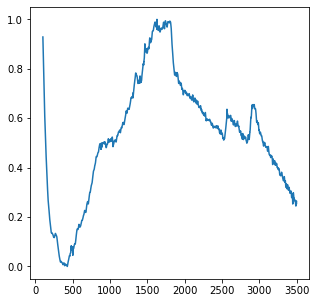


Is smoothing necessary?


KeyboardInterrupt: Interrupted by user

In [47]:
for i in range(len(txt_files)):
#for i in range(2):
    with open(directory + '/' + txt_files[i], 'r') as f:
        data=np.genfromtxt(f,delimiter='\t')
        normd_data=array_norm(data[:,1])
        figa=plt.figure(3, figsize=(5,5))
        plt.plot(data[:,0],normd_data)
        plt.show()
        print('\nIs smoothing necessary?')
        smooth_ans=input('(y=YES ; other=NO): ')
        if smooth_ans == checkok:
            smooth_data=smooth(normd_data, box_smooth)
            normd_data=array_norm(smooth_data)
        print('\nIs baseline substraction needed?')
        base_ans=input('(y=YES ; other=NO): ')
        if base_ans == checkok:
            basd_data=baseline_find(normd_data, lambd, pp)
            normd_data=array_norm(basd_data)
        normd_data=array_norm(normd_data)
        
        fig2=plt.figure(4, figsize=(5,5))
        plt.plot(data[:,0],normd_data, color='#011f4b')
        plt.xlabel('Wavenumber (cm$^⁻$$^1$)', fontsize=14)
        plt.ylabel('Normalized Intensity (a.u.)', fontsize=14)
        plt.title('Raman shift, laser:532nm', fontsize=14)
        plt.minorticks_on()
        plt.tick_params(direction='in', which='major', length=6)
        plt.tick_params(direction='in', which='minor', length=3)
        
 
        if max(data[:,0]) > I2Dpeak:
            plt.axvline(x=I2Dpeak, linestyle='--', color='#5e4a6f')
            plt.text(x=I2Dpeak+50, y=0.99*max(normd_data), s='2D', fontsize=14, color='#5e4a6f')
            plt.axvline(x=IDpeak, linestyle='--', color='#371e4c')
            plt.text(x=IDpeak-200, y=0.99*max(normd_data), s='D', fontsize=14, color='#371e4c')
            plt.axvline(x=IGpeak, linestyle='--', color='#4b345d')
            plt.text(x=IGpeak+50, y=0.99*max(normd_data), s='G', fontsize=14, color='#4b345d')
        elif max(data[:,0]) < I2Dpeak:
            plt.axvline(x=IDpeak, linestyle='--', color='#371e4c')
            plt.text(x=IDpeak+10, y=0.99*max(normd_data), s='D', fontsize=14, color='#371e4c')
            plt.axvline(x=IGpeak, linestyle='--', color='#4b345d')
            plt.text(x=IGpeak+10, y=0.99*max(normd_data), s='G', fontsize=14, color='#4b345d')
        plt.savefig('/home/dasilvatousch/Jupyter/Temp_Plots/S-Bsl-'+txt_files[i][:-4]+'.png', dpi=100)
        plt.show()